In [1]:
# 引入依赖库
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from models import *
from utils import *
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# 必要参数定义
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 训练设备,如果NVIDIA GPU已配置，会自动使用GPU训练
train_ratio = 0.8  # 训练集比例
val_ratio = 0.1  # 验证集比例
test_ratio = 0.1  # 测试集比例
batch_size = 50  # 批大小，若用CPU，建议为1
input_length = 128  # 每个batch的输入数据长度
output_length = 1  # 每个batch的输出数据长度，1为单步预测
loss_function = 'MSE'  # 损失函数定义
learning_rate = 0.001  # 基础学习率
weight_decay = 0.001  # 权重衰减系数
num_blocks = 2 # lstm堆叠次数
dim = 128  # 隐层维度
interval_length = 25000  # 预测数据长度，最长不可以超过总数据条数
scalar = True  # 是否使用归一化
scalar_contain_labels = True  # 归一化过程是否包含目标值的历史数据
target_value = 'mean_temp'  # 需要预测的列名，可以在excel中查看
# 多步，单步标签 #这里有个小问题只能实现单步不用改这个
if output_length > 1:
    forecasting_model = 'multi_steps'
else:
    forecasting_model = 'one_steps'

In [3]:
csv_path = "./london_weather.csv"
df = pd.read_csv(csv_path)

In [4]:
# 原始数据集存在重复项，要进行去重
df.drop_duplicates(subset=["date"],keep='first',inplace=True)

In [5]:
# checking null values in our dataset
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

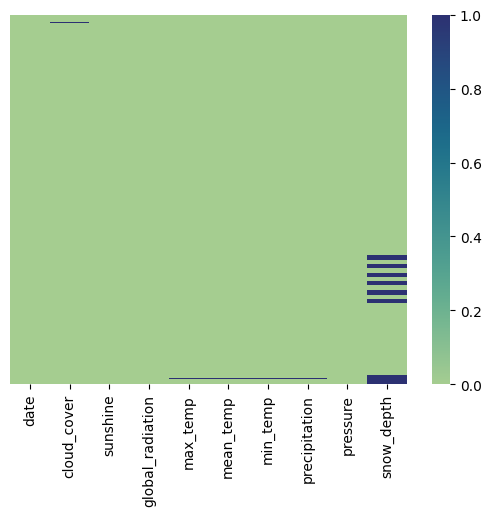

In [6]:
import seaborn as sns
sns.heatmap(df.isna(),yticklabels=False,cmap='crest')
plt.show()

In [7]:
df.drop('snow_depth',axis=1)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0
...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0


In [8]:
# 使用每一列的中位数填充缺失值
df = df.fillna(df.median())

In [9]:
# checking null values in our dataset
df.isna().sum()

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [10]:
df_1=df.copy()

In [11]:
# getting the datatypes of all the columns having null values
# first storing all the column names in a list having null values
col = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
df = df[col]
df[col].dtypes

cloud_cover         float64
sunshine            float64
global_radiation    float64
max_temp            float64
mean_temp           float64
min_temp            float64
precipitation       float64
pressure            float64
snow_depth          float64
dtype: object

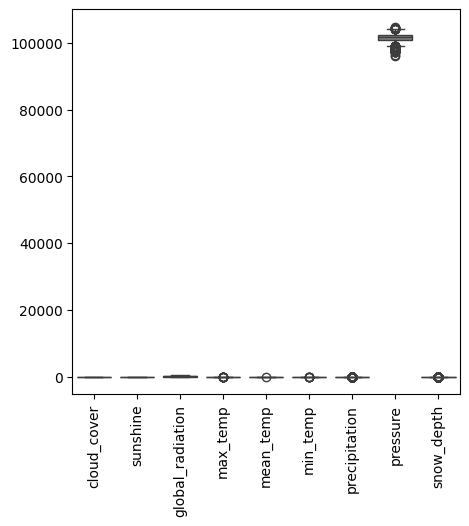

In [12]:
# plotting a boxplot
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

In [13]:
# getting the quartile one and quartile 3 values of each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
# finally calculating the interquartile range IQR
IQR = Q3 - Q1

In [14]:
# if the values fall behind Q1 - (1.5 * IQR) or above Q3 + 1.5*IQR,
#then it is been defined as outlier
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

cloud_cover            0
sunshine               0
global_radiation       0
max_temp              11
mean_temp              1
min_temp               5
precipitation       2105
pressure             243
snow_depth           140
dtype: int64

In [15]:
mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
mask

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
15336,False,False,False,False,False,False,False,True,False
15337,False,False,False,False,False,False,False,True,False
15338,False,False,False,False,False,False,False,True,False
15339,False,False,False,False,False,False,False,False,False


In [16]:
for i in mask.columns:
    df[i].astype('float')
    temp = df[i].median()
    df.loc[mask[i], i] = temp

In [17]:
# outliers are now being handled and are replaced with that column's median value
((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

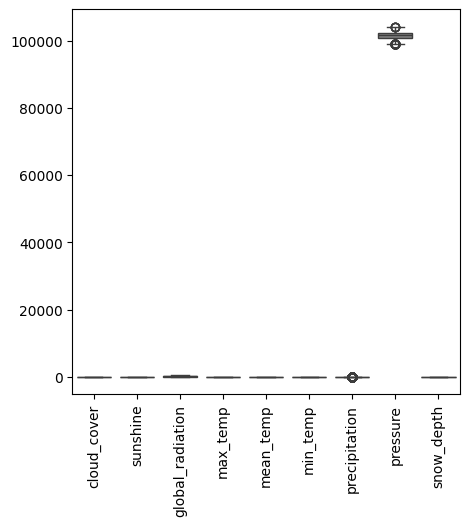

In [18]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

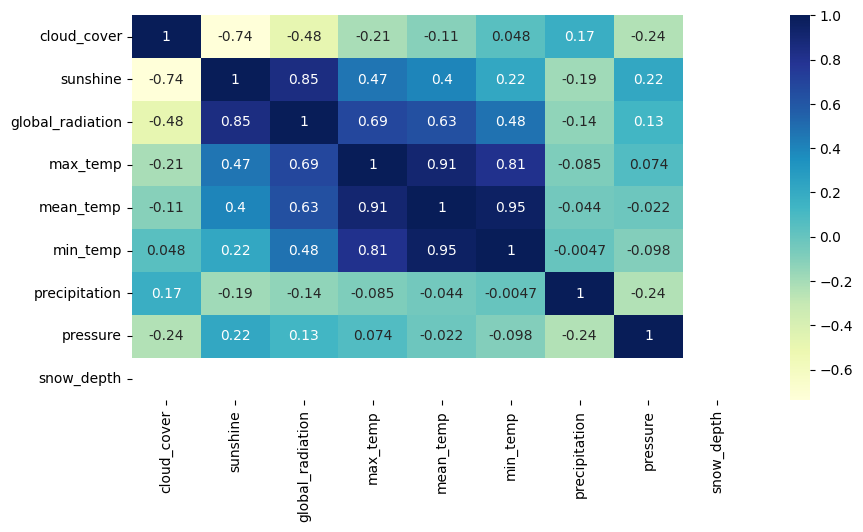

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.show()

In [20]:
feature_keys = [
    'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure'
]

date_time_key = "date"

In [21]:
df = pd.concat([df_1['date'], df], axis=1)

In [22]:
print(df.head())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         0.0  
1      -7.5            0.0  102530.0         0.0  
2      -7.2            0.0  102050.0         0.0  
3      -6.5            0.0  100840.0         0.0  
4      -1.4            0.0  102250.0         0.0  


In [23]:
# 删除多余的 'date' 列，保留第一个
df = df.loc[:, ~df.columns.duplicated()]

# 删除 'snow_depth' 列
df = df.drop(columns=['snow_depth'])

# 检查结果
print(df.head())


       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  
0      -7.5            0.4  101900.0  
1      -7.5            0.0  102530.0  
2      -7.2            0.0  102050.0  
3      -6.5            0.0  100840.0  
4      -1.4            0.0  102250.0  


In [24]:
features = df[feature_keys]
features.index = df[date_time_key]
features.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
date,,,,,,,,
19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0
19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0
19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0
19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0
19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0


In [25]:
df['Date Time'] = pd.to_datetime(df['date'])  # 确保时间列是日期时间格式
df.set_index('Date Time', inplace=True)  # 将时间列设为索引


# 选择目标列和观察列
target = df['mean_temp']
observed_cov = df[['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure']]

In [26]:
selected_columns = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure',
                   'mean_temp']

In [27]:
df_1=df[selected_columns]
df_1.head()

,cloud_cover,sunshine,global_radiation,max_temp,min_temp,precipitation,pressure,mean_temp
Date Time,,,,,,,,
1970-01-01 00:00:00.019790101,2.0,7.0,52.0,2.3,-7.5,0.4,101900.0,-4.1
1970-01-01 00:00:00.019790102,6.0,1.7,27.0,1.6,-7.5,0.0,102530.0,-2.6
1970-01-01 00:00:00.019790103,5.0,0.0,13.0,1.3,-7.2,0.0,102050.0,-2.8
1970-01-01 00:00:00.019790104,8.0,0.0,13.0,-0.3,-6.5,0.0,100840.0,-2.6
1970-01-01 00:00:00.019790105,6.0,2.0,29.0,5.6,-1.4,0.0,102250.0,-0.8


In [28]:
#  读取数据
df = df_1[:interval_length]
features_num = 8  # 请手动输入特征维度数量
if features_num > 1:
    features_ = df.values
else:
    features_ = df[target_value].values
labels_ = df[target_value].values
# 初步划分训练集、验证集、测试集
split_train_val, split_val_test = int(len(features_)*train_ratio),                                  int(len(features_)*train_ratio)+int(len(features_)*val_ratio)

In [29]:
#  数据标准化
if scalar:
    #min-max scalar
    train_features_ = features_[:split_train_val]
    val_test_features_ = features_[split_train_val:]
    scalar = preprocessing.MinMaxScaler()
    if features_num == 1:
        train_features_ = np.expand_dims(train_features_, axis=1)
        val_test_features_ = np.expand_dims(val_test_features_, axis=1)
    train_features_ = scalar.fit_transform(train_features_)
    val_test_features_ = scalar.transform(val_test_features_)
    # 重新将数据进行拼接
    features_ = np.vstack([train_features_, val_test_features_])
    if scalar_contain_labels:
        labels_ = features_[:, -1]

if len(features_.shape) == 1:
    features_ = np.expand_dims(features_,0).T
features, labels = get_rolling_window_multistep(output_length, 0, input_length,
                                                features_.T, np.expand_dims(labels_, 0))

data preparing: 100%|██████████| 15213/15213 [06:16<00:00, 40.36it/s]


In [30]:
#  构建数据集
labels = torch.squeeze(labels, dim=1)
features = features.to(torch.float32)
labels = labels.to(torch.float32)
split_train_val, split_val_test = int(len(features)*train_ratio), int(len(features)*train_ratio)+int(len(features)*val_ratio)
train_features, train_labels = features[:split_train_val], labels[:split_train_val]
val_features, val_labels = features[split_train_val:split_val_test], labels[split_train_val:split_val_test]
test_features, test_labels = features[split_val_test:], labels[split_val_test:]

In [31]:
#  数据管道构建，此处采用torch高阶API
train_Datasets = TensorDataset(train_features.to(device), train_labels.to(device))
train_Loader = DataLoader(batch_size=batch_size, dataset=train_Datasets)
val_Datasets = TensorDataset(val_features.to(device), val_labels.to(device))
val_Loader = DataLoader(batch_size=batch_size, dataset=val_Datasets)
test_Datasets = TensorDataset(test_features.to(device), test_labels.to(device))
test_Loader = DataLoader(batch_size=batch_size, dataset=test_Datasets)

In [32]:
#  模型定义
model = LSTMMain(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)

model.to(device)
if loss_function == 'MSE':
    loss_func = nn.MSELoss(reduction='mean')
    #loss_func = nn.SmoothL1Loss(reduction='mean')

In [33]:
#  训练代数定义
epochs = 31
#  优化器定义，学习率衰减定义
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.00001)

In [34]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import r2_score

# Lists to store MAE, RMSE, and R² for each epoch
train_mae_history = []
train_rmse_history = []
train_r2_history = []
val_mae_history = []
val_rmse_history = []
val_r2_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss_sum = 0
    train_mae_sum = 0
    train_rmse_sum = 0
    all_train_preds = []
    all_train_labels = []
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()
        
        # Store predictions and labels for R² calculation
        all_train_preds.append(prediction.detach().cpu().numpy())
        all_train_labels.append(label_.detach().cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        train_mae_sum += mae
        train_rmse_sum += rmse

    # Calculate R² for training data for the entire epoch
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    train_r2 = r2_score(all_train_labels, all_train_preds)
    
    # Record each epoch's metrics
    train_mae_history.append(train_mae_sum / (step + 1))  # Average MAE per epoch
    train_rmse_history.append(train_rmse_sum / (step + 1))  # Average RMSE per epoch
    train_r2_history.append(train_r2)

    print(f"Epoch {epoch}: Train Loss = {train_loss_sum:.4f}, Train MAE = {train_mae_history[-1]:.4f}, Train RMSE = {train_rmse_history[-1]:.4f}, Train R² = {train_r2:.4f}")

    # Validation
    model.eval()
    val_loss_sum = 0
    val_mae_sum = 0
    val_rmse_sum = 0
    all_val_preds = []
    all_val_labels = []
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()
        
        # Store predictions and labels for R² calculation
        all_val_preds.append(prediction.cpu().numpy())
        all_val_labels.append(label_.cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        val_mae_sum += mae
        val_rmse_sum += rmse

    # Calculate R² for validation data for the entire epoch
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    val_r2 = r2_score(all_val_labels, all_val_preds)
    
    # Record each epoch's metrics
    val_mae_history.append(val_mae_sum / (val_step + 1))  # Average MAE per epoch
    val_rmse_history.append(val_rmse_sum / (val_step + 1))  # Average RMSE per epoch
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch}: Val Loss = {val_loss_sum:.4f}, Val MAE = {val_mae_history[-1]:.4f}, Val RMSE = {val_rmse_history[-1]:.4f}, Val R² = {val_r2:.4f}")

    # Save best model
    if epoch == 0 or val_loss_sum < val_best:
        val_best = val_loss_sum
        #torch.save(model.state_dict(), './TCN_LSTM_KAN/TCN_LSTM_KAN_best')  # Save best weights
        print("val_best change")
    '''
    # Save model every 10 epochs
    if epoch % 10 == 0 and epoch >= 10:
        torch.save(model.state_dict(), f'./TCN_LSTM_KAN/TCN_LSTM_KAN_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")
    '''

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 0: Train Loss = 4.6203, Train MAE = 0.0945, Train RMSE = 0.1097, Train R² = 0.2765
Epoch 0: Val Loss = 0.1043, Val MAE = 0.0464, Val RMSE = 0.0571, Val R² = 0.8627
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 1: Train Loss = 1.0094, Train MAE = 0.0521, Train RMSE = 0.0621, Train R² = 0.8420
Epoch 1: Val Loss = 0.0478, Val MAE = 0.0310, Val RMSE = 0.0387, Val R² = 0.9365
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 2: Train Loss = 0.5827, Train MAE = 0.0393, Train RMSE = 0.0473, Train R² = 0.9089
Epoch 2: Val Loss = 0.0385, Val MAE = 0.0277, Val RMSE = 0.0347, Val R² = 0.9488
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 3: Train Loss = 0.3380, Train MAE = 0.0287, Train RMSE = 0.0357, Train R² = 0.9472
Epoch 3: Val Loss = 0.0329, Val MAE = 0.0253, Val RMSE = 0.0320, Val R² = 0.9563
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 4: Train Loss = 0.3378, Train MAE = 0.0289, Train RMSE = 0.0359, Train R² = 0.9472
Epoch 4: Val Loss = 0.0347, Val MAE = 0.0263, Val RMSE = 0.0329, Val R² = 0.9539


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 5: Train Loss = 0.3281, Train MAE = 0.0283, Train RMSE = 0.0353, Train R² = 0.9487
Epoch 5: Val Loss = 0.0341, Val MAE = 0.0261, Val RMSE = 0.0326, Val R² = 0.9547


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 6: Train Loss = 0.3146, Train MAE = 0.0276, Train RMSE = 0.0345, Train R² = 0.9509
Epoch 6: Val Loss = 0.0400, Val MAE = 0.0284, Val RMSE = 0.0353, Val R² = 0.9469


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 7: Train Loss = 0.3145, Train MAE = 0.0276, Train RMSE = 0.0345, Train R² = 0.9509
Epoch 7: Val Loss = 0.0398, Val MAE = 0.0284, Val RMSE = 0.0352, Val R² = 0.9473


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 8: Train Loss = 0.3054, Train MAE = 0.0271, Train RMSE = 0.0339, Train R² = 0.9523
Epoch 8: Val Loss = 0.0381, Val MAE = 0.0277, Val RMSE = 0.0345, Val R² = 0.9495


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 9: Train Loss = 0.3028, Train MAE = 0.0270, Train RMSE = 0.0337, Train R² = 0.9527
Epoch 9: Val Loss = 0.0354, Val MAE = 0.0266, Val RMSE = 0.0332, Val R² = 0.9530


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 10: Train Loss = 0.2969, Train MAE = 0.0266, Train RMSE = 0.0334, Train R² = 0.9536
Epoch 10: Val Loss = 0.0355, Val MAE = 0.0267, Val RMSE = 0.0332, Val R² = 0.9530


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 11: Train Loss = 0.2938, Train MAE = 0.0265, Train RMSE = 0.0332, Train R² = 0.9541
Epoch 11: Val Loss = 0.0349, Val MAE = 0.0265, Val RMSE = 0.0330, Val R² = 0.9536


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 12: Train Loss = 0.2907, Train MAE = 0.0263, Train RMSE = 0.0330, Train R² = 0.9546
Epoch 12: Val Loss = 0.0353, Val MAE = 0.0266, Val RMSE = 0.0331, Val R² = 0.9532


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 13: Train Loss = 0.2867, Train MAE = 0.0261, Train RMSE = 0.0327, Train R² = 0.9552
Epoch 13: Val Loss = 0.0340, Val MAE = 0.0261, Val RMSE = 0.0325, Val R² = 0.9548


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 14: Train Loss = 0.2833, Train MAE = 0.0260, Train RMSE = 0.0325, Train R² = 0.9557
Epoch 14: Val Loss = 0.0339, Val MAE = 0.0261, Val RMSE = 0.0325, Val R² = 0.9550


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 15: Train Loss = 0.2809, Train MAE = 0.0259, Train RMSE = 0.0324, Train R² = 0.9561
Epoch 15: Val Loss = 0.0328, Val MAE = 0.0256, Val RMSE = 0.0319, Val R² = 0.9565
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 16: Train Loss = 0.2789, Train MAE = 0.0258, Train RMSE = 0.0323, Train R² = 0.9564
Epoch 16: Val Loss = 0.0322, Val MAE = 0.0254, Val RMSE = 0.0317, Val R² = 0.9572
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 17: Train Loss = 0.2769, Train MAE = 0.0257, Train RMSE = 0.0322, Train R² = 0.9567
Epoch 17: Val Loss = 0.0318, Val MAE = 0.0252, Val RMSE = 0.0315, Val R² = 0.9577
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 18: Train Loss = 0.2751, Train MAE = 0.0256, Train RMSE = 0.0321, Train R² = 0.9570
Epoch 18: Val Loss = 0.0312, Val MAE = 0.0249, Val RMSE = 0.0311, Val R² = 0.9586
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 19: Train Loss = 0.2735, Train MAE = 0.0255, Train RMSE = 0.0320, Train R² = 0.9572
Epoch 19: Val Loss = 0.0303, Val MAE = 0.0245, Val RMSE = 0.0307, Val R² = 0.9597
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 20: Train Loss = 0.2723, Train MAE = 0.0255, Train RMSE = 0.0319, Train R² = 0.9574
Epoch 20: Val Loss = 0.0292, Val MAE = 0.0241, Val RMSE = 0.0301, Val R² = 0.9613
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 21: Train Loss = 0.2734, Train MAE = 0.0255, Train RMSE = 0.0320, Train R² = 0.9573
Epoch 21: Val Loss = 0.0272, Val MAE = 0.0232, Val RMSE = 0.0290, Val R² = 0.9638
val_best change


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 22: Train Loss = 0.2878, Train MAE = 0.0263, Train RMSE = 0.0328, Train R² = 0.9550
Epoch 22: Val Loss = 0.0278, Val MAE = 0.0231, Val RMSE = 0.0294, Val R² = 0.9631


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 23: Train Loss = 0.4974, Train MAE = 0.0354, Train RMSE = 0.0423, Train R² = 0.9222
Epoch 23: Val Loss = 0.0280, Val MAE = 0.0232, Val RMSE = 0.0296, Val R² = 0.9628


/tmp/ipykernel_8844/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


KeyboardInterrupt: 

In [35]:
np.savez('./asb_icb_metrics_history_2.npz', 
         train_mae=train_mae_history, 
         train_rmse=train_rmse_history, 
         train_r2=train_r2_history, 
         val_mae=val_mae_history, 
         val_rmse=val_rmse_history, 
         val_r2=val_r2_history)


In [ ]:
import matplotlib.pyplot as plt

# 训练及验证循环
train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # 训练
    LSTMMain_model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = LSTMMain_model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(LSTMMain_model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)

    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    LSTMMain_model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = LSTMMain_model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print('val_loss = ' + str(val_loss_sum))

    if epoch == 0:
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(LSTMMain_model.state_dict(), './lstm_asb_icb_dcattention_0001/asb_icb_best')  # 保存最好权重
            print("val_best change")

    # 每隔10个epoch保存一次模型
    if epoch % 1 == 0 and epoch>=29:
        torch.save(LSTMMain_model.state_dict(), f'./lstm_asb_icb_dcattention_0001/asb_icb_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")

In [ ]:
#  测试集预测
LSTMMain_model.load_state_dict(torch.load('./lstm_asb_icb_dcattention_0001/asb_icb_epoch_33.pth'))  # 调用权重
test_loss_sum = 0
#  测试集inference
print("——————————————————————Testing Starts——————————————————————")
for step, (feature_, label_) in enumerate(test_Loader):
    feature_ = feature_.permute(0, 2, 1)
    with torch.no_grad():
         if step ==0:
            prediction = LSTMMain_model(feature_)
            pre_array = prediction.cpu()
            label_array = label_.cpu()
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
         else:
            prediction = LSTMMain_model(feature_)
            pre_array = np.vstack((pre_array, prediction.cpu()))
            label_array = np.vstack((label_array, label_.cpu()))
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
print("test loss = " + str(test_loss_sum))
print("——————————————————————Testing Ends——————————————————————")

——————————————————————Post-Processing——————————————————————


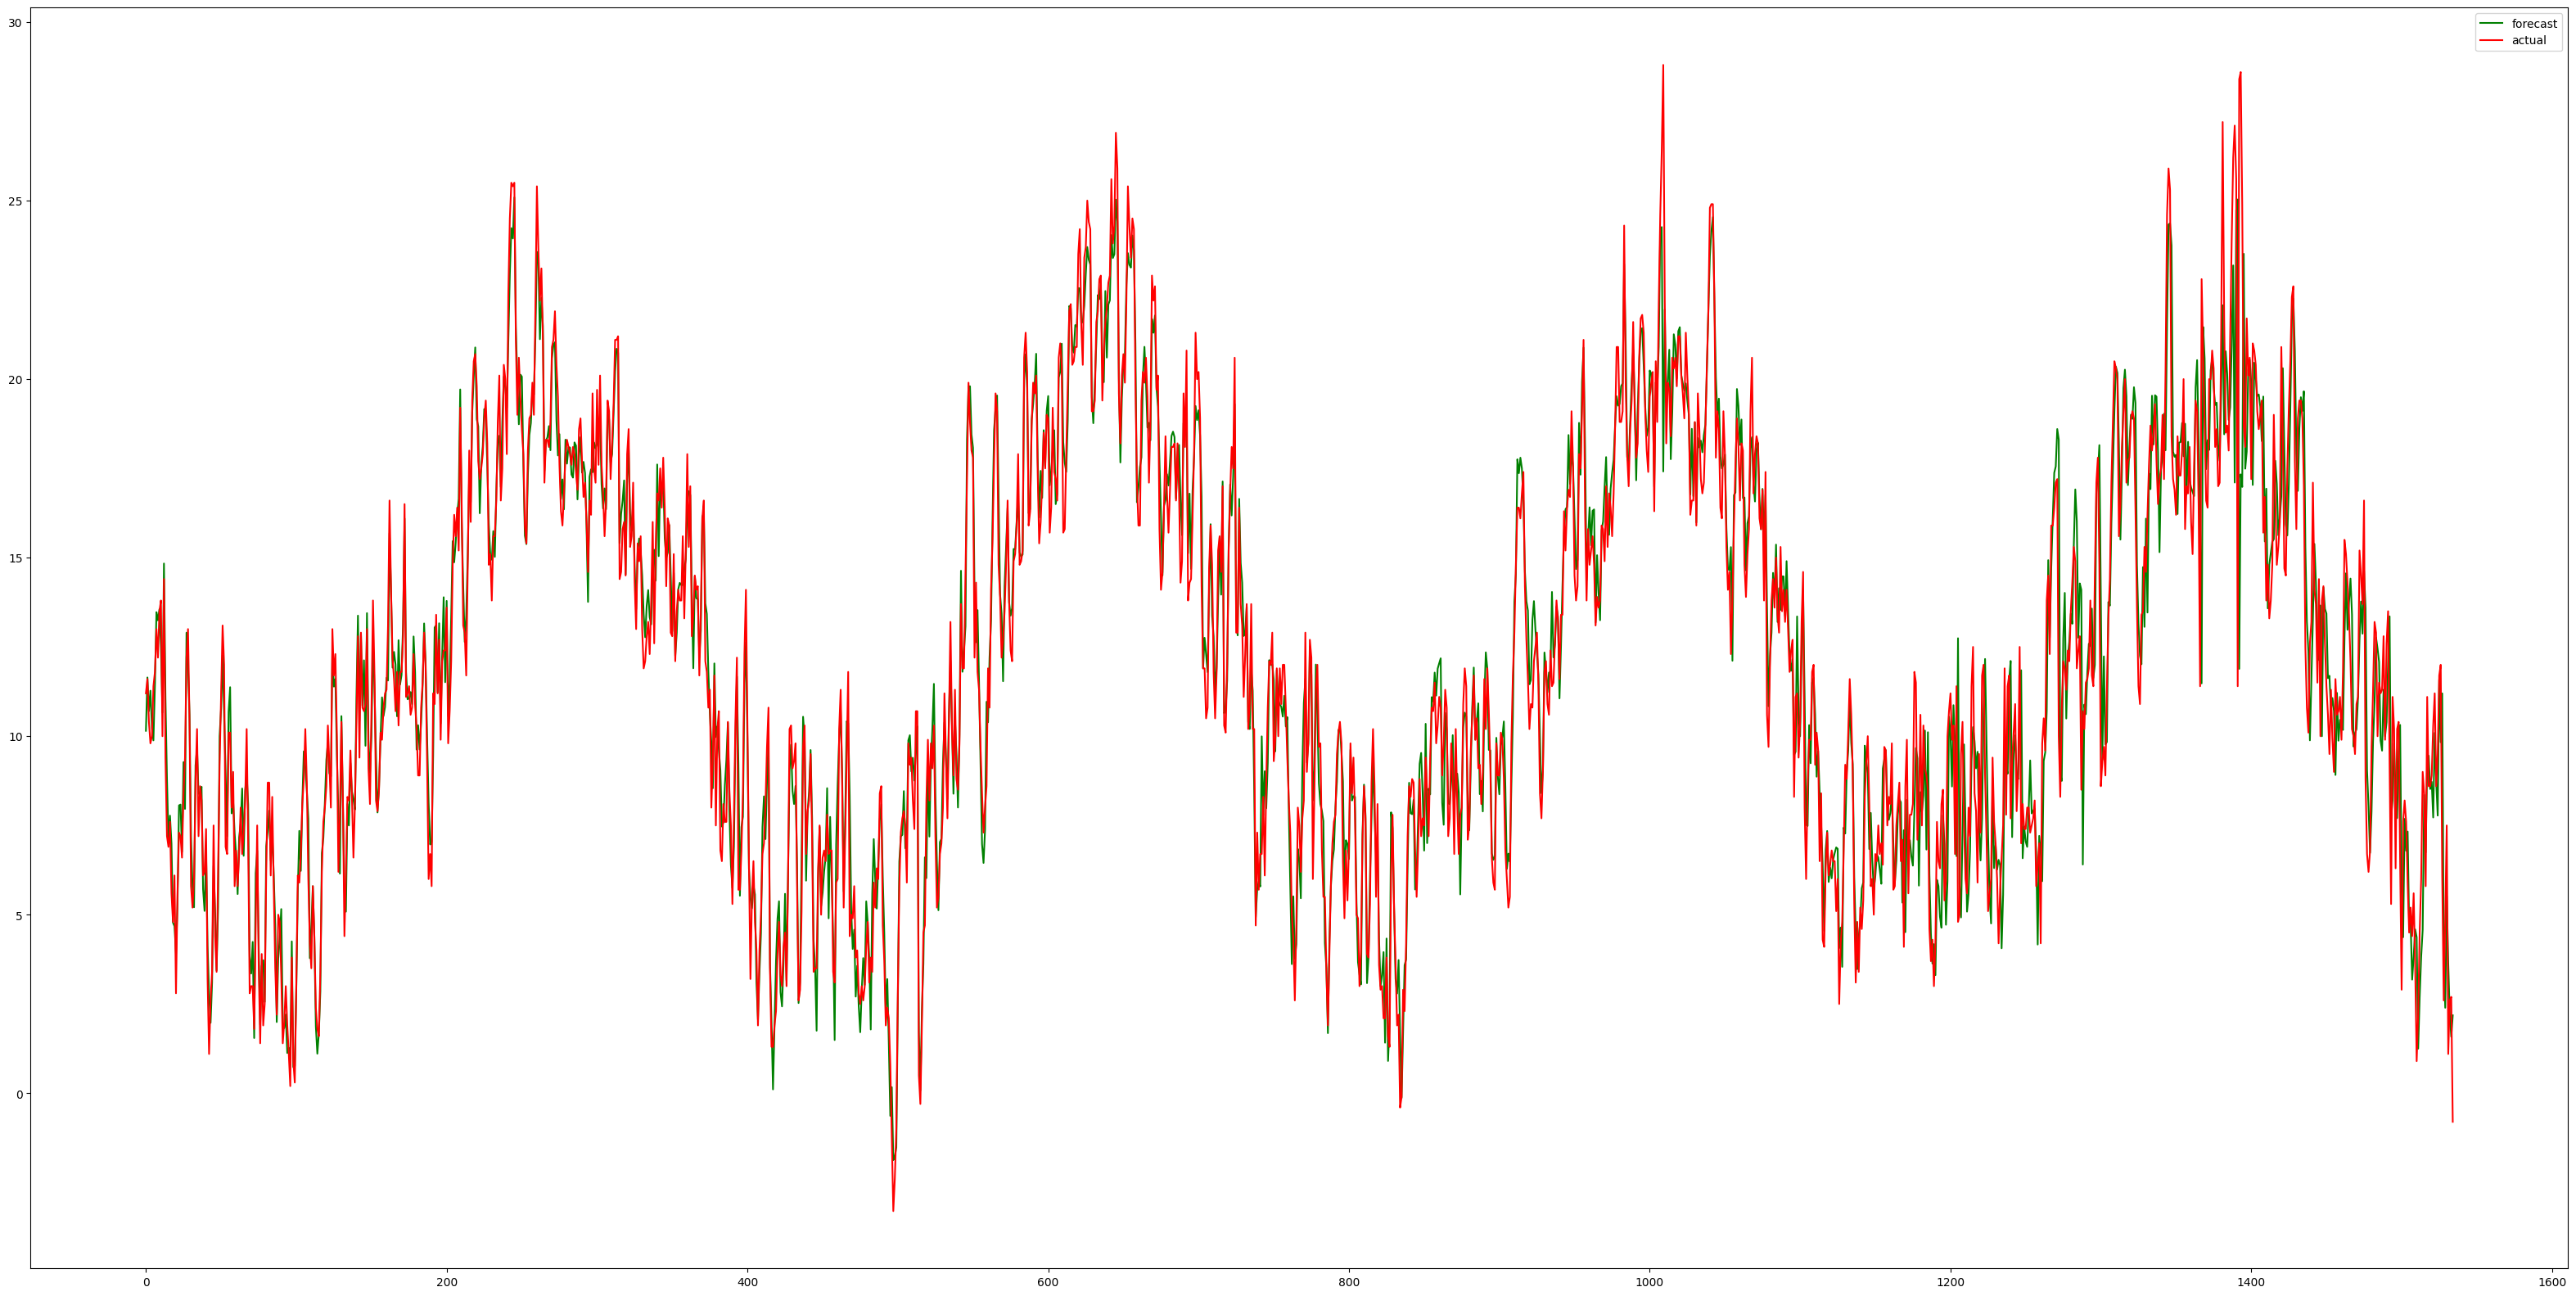

MSE score = 2.406948614744774
MAE score = 1.0315349686029291
RMSE score = 1.5514343733283642
MAPE score = 0.12871511302135324
R² = 0.9274365873239593


In [40]:
print("——————————————————————Post-Processing——————————————————————")
if scalar_contain_labels and scalar:
    pre_inverse = []
    test_inverse = []
    if features_num == 1 and output_length == 1:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    elif features_num > 1:
        if isinstance(pre_array, np.ndarray):
            pre_array = torch.from_numpy(pre_array)  # 确保 pre_array 是 torch.Tensor
        if isinstance(test_labels, np.ndarray):
            test_labels = torch.from_numpy(test_labels)  # 转换 test_labels 为 torch.Tensor
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(pre_array[0].shape[0], features_num-1), torch.unsqueeze(pre_array[pre_slice], dim=1)), 1))[:,-1]
            test_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(test_labels[0].shape[0], features_num-1), torch.unsqueeze(test_labels[pre_slice], dim=1)), 1))[:,-1]
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse)
        test_labels = np.array(test_inverse)
    else:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)

    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0], "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels, "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()

    # 计算衡量指标
    MSE_l = mean_squared_error(test_labels, pre_array)
    MAE_l = mean_absolute_error(test_labels, pre_array)
    RMSE_l = MSE_l ** 0.5  # RMSE 计算
    MAPE_l = mean_absolute_percentage_error(test_labels, pre_array)
    R2 = r2_score(test_labels, pre_array)
    
    print('MSE score = %s' % MSE_l)
    print('MAE score = %s' % MAE_l)
    print('RMSE score = %s' % RMSE_l)
    print('MAPE score = %s' % MAPE_l)
    print('R² = %s' % R2)

else:
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0].cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels.cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()

    MSE_l = mean_squared_error(test_labels.cpu(), pre_array)
    MAE_l = mean_absolute_error(test_labels.cpu(), pre_array)
    RMSE_l = MSE_l ** 0.5  # RMSE 计算
    MAPE_l = mean_absolute_percentage_error(test_labels.cpu(), pre_array)
    R2 = r2_score(test_labels.cpu(), pre_array)
    
    print('MSE score = %s' % MSE_l)
    print('MAE score = %s' % MAE_l)
    print('RMSE score = %s' % RMSE_l)
    print('MAPE score = %s' % MAPE_l)
    print('R² = %s' % R2)